# PySpark session

In [1]:
import os
from pyspark.sql import SparkSession

In [2]:
# Install OpenJDK
# !apt-get install openjdk-17-jdk-headless -qq > /dev/null

# Set JAVA_HOME and PATH
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk"
os.environ["PATH"] = f"/usr/lib/jvm/java-17-openjdk-amd64/bin:{os.environ['PATH']}"

spark = SparkSession.builder.getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/14 00:21:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# EDA utility functions

In [3]:
from pyspark.sql import DataFrame, functions as F

def basic_info(df, name):
    print(f"\n=== {name} ===")
    print("Row count:", df.count())
    df.printSchema()


def null_counts(df, name):
    print(f"\n--- Null Value Counts: {name} ---")
    df.select(
        [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]
    ).show(truncate=False)


def distinct_values(df, cols, name):
    print(f"\n--- Distinct Values: {name} ---")
    for c in cols:
        if c in df.columns:
            print(f"\nColumn: {c}")
            df.groupBy(c).count().orderBy("count", ascending=False).show(
                10, truncate=False
            )

def numeric_summary(df, cols, name):
    print(f"\n--- Numeric Summary: {name} ---")
    for c in cols:
        if c in df.columns:
            print(f"\nColumn: {c}")
            df.describe([c]).show()

def compare_cols(col1, col2):
    return set(col1) == set(col2)

In [4]:
reservations = spark.read.option("header", True).csv(
    "data/raw/customer-reservations.csv", inferSchema=True
)
bookings = spark.read.option("header", True).csv(
    "data/raw/hotel-booking.csv", inferSchema=True
)

# Basic Info

In [5]:
basic_info(reservations, "Customer Reservations")
basic_info(bookings, "Hotel Bookings")


=== Customer Reservations ===
Row count: 36275
root
 |-- Booking_ID: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_date: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- booking_status: string (nullable = true)


=== Hotel Bookings ===
Row count: 78703
root
 |-- hotel: string (nullable = true)
 |-- booking_status: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (n

# Null Counts

In [6]:
null_counts(reservations, "Customer Reservations")
null_counts(bookings, "Hotel Bookings")


--- Null Value Counts: Customer Reservations ---
+----------+-----------------------+--------------------+---------+------------+-------------+------------+-------------------+------------------+--------------+
|Booking_ID|stays_in_weekend_nights|stays_in_week_nights|lead_time|arrival_year|arrival_month|arrival_date|market_segment_type|avg_price_per_room|booking_status|
+----------+-----------------------+--------------------+---------+------------+-------------+------------+-------------------+------------------+--------------+
|0         |0                      |0                   |0        |0           |0            |0           |0                  |0                 |0             |
+----------+-----------------------+--------------------+---------+------------+-------------+------------+-------------------+------------------+--------------+


--- Null Value Counts: Hotel Bookings ---
+-----+--------------+---------+------------+-------------+------------------------+------------

# Distinct Values (categorical checks)

In [7]:
distinct_values(reservations, ["booking_status", "market_segment_type"], "Reservations")
distinct_values(bookings, ["booking_status", "market_segment"], "Bookings")


--- Distinct Values: Reservations ---

Column: booking_status
+--------------+-----+
|booking_status|count|
+--------------+-----+
|Not_Canceled  |24390|
|Canceled      |11885|
+--------------+-----+


Column: market_segment_type
+-------------------+-----+
|market_segment_type|count|
+-------------------+-----+
|Online             |23214|
|Offline            |10528|
|Corporate          |2017 |
|Complementary      |391  |
|Aviation           |125  |
+-------------------+-----+


--- Distinct Values: Bookings ---

Column: booking_status
+--------------+-----+
|booking_status|count|
+--------------+-----+
|0             |50224|
|1             |28479|
+--------------+-----+



# Numeric Summaries

In [8]:
numeric_summary(reservations, ["lead_time", "avg_price_per_room"], "Reservations")
numeric_summary(bookings, ["lead_time", "avg_price_per_room"], "Bookings")


--- Numeric Summary: Reservations ---

Column: lead_time
+-------+-----------------+
|summary|        lead_time|
+-------+-----------------+
|  count|            36275|
|   mean|85.23255685733976|
| stddev|85.93081669923292|
|    min|                0|
|    max|              443|
+-------+-----------------+


Column: avg_price_per_room
+-------+------------------+
|summary|avg_price_per_room|
+-------+------------------+
|  count|             36275|
|   mean| 103.4235390764958|
| stddev| 35.08942403637024|
|    min|               0.0|
|    max|             540.0|
+-------+------------------+


--- Numeric Summary: Bookings ---

Column: lead_time
+-------+------------------+
|summary|         lead_time|
+-------+------------------+
|  count|             78703|
|   mean|101.29846384508849|
| stddev|106.20064931641437|
|    min|                 0|
|    max|               737|
+-------+------------------+


Column: avg_price_per_room
+-------+------------------+
|summary|avg_price_per_roo

# Reservation Graphs

In [9]:
res_pd = reservations.toPandas()

<Axes: >

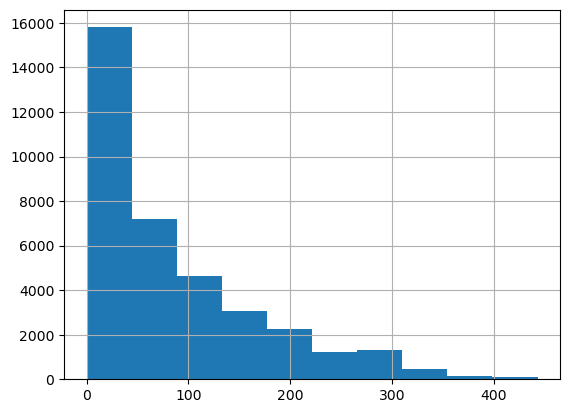

In [10]:
res_pd["lead_time"].hist()

<Axes: >

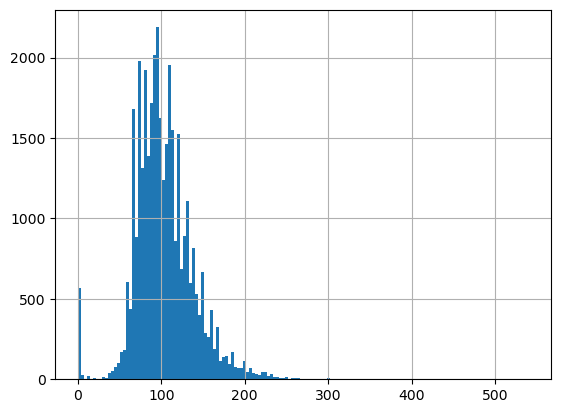

In [11]:
res_pd["avg_price_per_room"].hist(bins=150)

<Axes: >

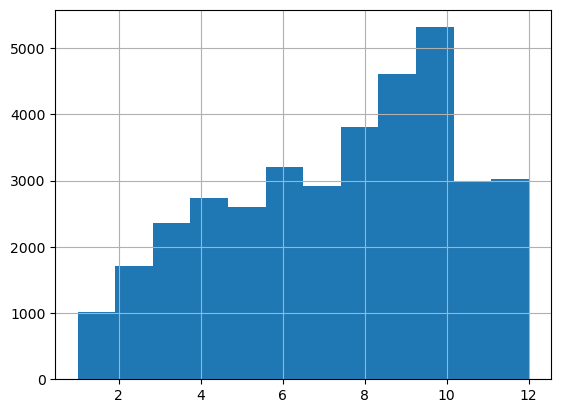

In [12]:
res_pd["arrival_month"].hist(bins=12)

<Axes: >

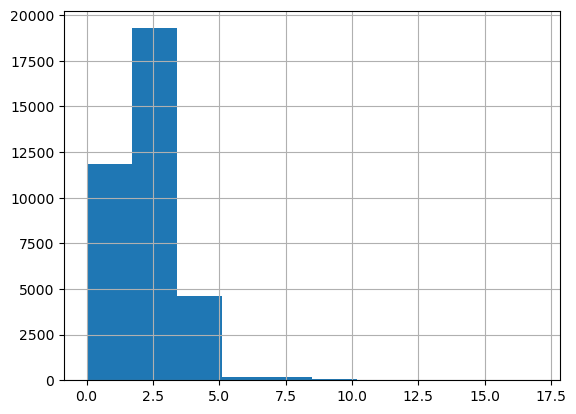

In [13]:
res_pd["stays_in_week_nights"].hist()

<Axes: >

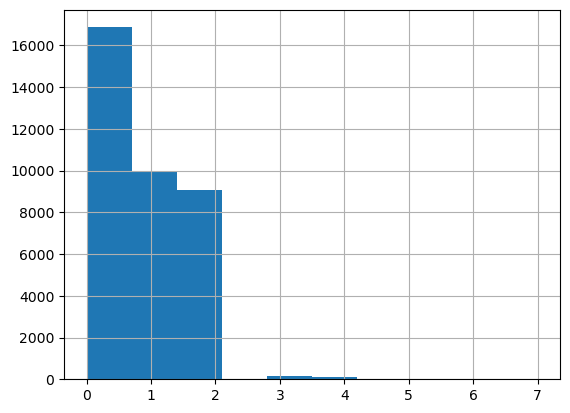

In [14]:
res_pd["stays_in_weekend_nights"].hist()

# Booking Graphs

In [15]:
booking_pd = bookings.toPandas()

<Axes: >

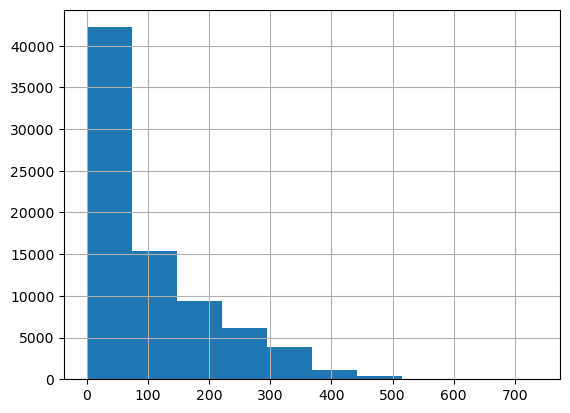

In [16]:
booking_pd["lead_time"].hist()

<Axes: >

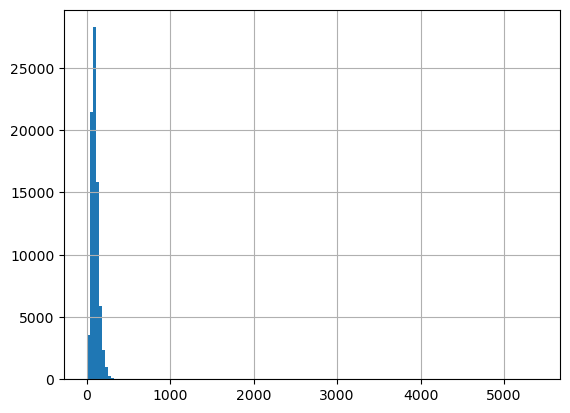

In [17]:
booking_pd["avg_price_per_room"].hist(bins=150)

<Axes: >

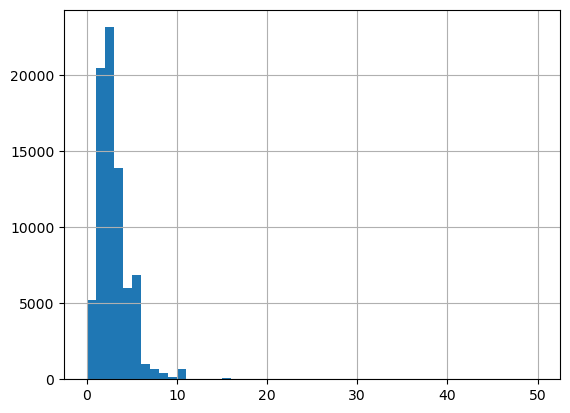

In [18]:
booking_pd["stays_in_week_nights"].hist(bins=50)

# Data cleaning and merging

In [19]:
def get_shared_cols(df1, df2):
    cols1 = set(df1.dtypes)
    cols2 = set(df2.dtypes)
    intersection = cols1.intersection(cols2)
    print(list(intersection))
def get_unique_cols(df1, df2):
    cols1 = set(df1.dtypes)
    cols2 = set(df2.dtypes)
    unique = cols1 - cols2
    print(list(unique))


In [20]:
print("Reservations:")
reservations.printSchema()
print("Bookings")
bookings.printSchema()

Reservations:
root
 |-- Booking_ID: string (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_date: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- booking_status: string (nullable = true)

Bookings
root
 |-- hotel: string (nullable = true)
 |-- booking_status: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)
 |-- arrival_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)

In [21]:
print("Shared columns")
get_shared_cols(reservations, bookings)
print("Unique columns")
get_unique_cols(reservations, bookings)
get_unique_cols(bookings, reservations)

Shared columns
[('lead_time', 'int'), ('stays_in_week_nights', 'int'), ('market_segment_type', 'string'), ('avg_price_per_room', 'double'), ('stays_in_weekend_nights', 'int'), ('arrival_year', 'int')]
Unique columns
[('Booking_ID', 'string'), ('booking_status', 'string'), ('arrival_month', 'int'), ('arrival_date', 'int')]
[('hotel', 'string'), ('arrival_date_day_of_month', 'int'), ('email', 'string'), ('country', 'string'), ('arrival_month', 'string'), ('booking_status', 'int'), ('arrival_date_week_number', 'int')]


Booking_ID can be dropped, as it does not have a matching ID in the bookings dataframe.
arrival_date_week_number can be dropped because it is redundant with arrival month date and year.

In [22]:
reservations_new = reservations.drop("Booking_ID")
bookings_new = bookings.drop("arrival_date_week_number")

We can also see that booking_status is shared between the dataframes but has different types. The reservations dataframe uses a string, "Not_Canceled" and "Canceled" and bookings uses an int, 0 and 1. We will make reservations conform to bookings format.

In [23]:
from pyspark.sql.functions import when,col
reservations_new.select("booking_status").show(10)
reservations_new = reservations_new.withColumn("booking_status", when(col("booking_status") == "Canceled", 1).otherwise(0))
reservations_new.select("booking_status").show(10)

+--------------+
|booking_status|
+--------------+
|  Not_Canceled|
|  Not_Canceled|
|      Canceled|
|      Canceled|
|      Canceled|
|      Canceled|
|  Not_Canceled|
|  Not_Canceled|
|  Not_Canceled|
|  Not_Canceled|
+--------------+
only showing top 10 rows
+--------------+
|booking_status|
+--------------+
|             0|
|             0|
|             1|
|             1|
|             1|
|             1|
|             0|
|             0|
|             0|
|             0|
+--------------+
only showing top 10 rows


The same problem exists for arrival_month, in bookings it is a string, and in reservations it is an int. We will make bookings conform to reservations.

In [24]:
bookings_new = bookings_new.withColumn("arrival_month",
    when(col("arrival_month") == "January", 1)
    .when(col("arrival_month") == "February", 2)
    .when(col("arrival_month") == "March", 3)
    .when(col("arrival_month") == "April", 4)
    .when(col("arrival_month") == "May", 5)
    .when(col("arrival_month") == "June", 6)
    .when(col("arrival_month") == "July", 7)
    .when(col("arrival_month") == "August", 8)
    .when(col("arrival_month") == "September", 9)
    .when(col("arrival_month") == "October", 10)
    .when(col("arrival_month") == "November", 11)
    .when(col("arrival_month") == "December", 12)
    .otherwise(0))

The column for arrival day of the month is named differently in reservations and bookings. We have renamed both to "arrival_day" to make the column more clear.

Doing this reveals Feb 29, 2018, which is not a valid date, so we set it to March 1, 2018.

In [25]:
reservations_new = reservations_new.withColumnRenamed("arrival_date", "arrival_day")
bookings_new = bookings_new.withColumnRenamed("arrival_date_day_of_month", "arrival_day")

In [26]:
from pyspark.sql.functions import concat_ws, col, to_date, lit

reservations_new = reservations_new.withColumn(
    "arrival_date",
    concat_ws("-",
        col("arrival_year").cast("string"),
        col("arrival_month").cast("string"),
        col("arrival_day").cast("string")
    )
)

bookings_new = bookings_new.withColumn(
    "arrival_date",
    concat_ws("-",
        col("arrival_year").cast("string"),
        col("arrival_month").cast("string"),
        col("arrival_day").cast("string")
    )
)


reservations_new = reservations_new.drop("arrival_year", "arrival_month", "arrival_day")
bookings_new = bookings_new.drop("arrival_year", "arrival_month", "arrival_day")


In [27]:
reservations_new = reservations_new.withColumn("arrival_date", when(col("arrival_date") == "2018-02-29", "2018-03-01"))
bookings_new = bookings_new.withColumn("arrival_date", when(col("arrival_date") == "2018-02-29", "2018-03-01"))

In [28]:
from pyspark.sql.functions import expr

reservations_new = reservations_new.withColumn(
    "total_stay_nights",
    (col("stays_in_weekend_nights") + col("stays_in_week_nights"))
)

bookings_new = bookings_new.withColumn(
    "total_stay_nights",
    (col("stays_in_weekend_nights") + col("stays_in_week_nights"))
)

reservations_new = reservations_new.drop("stays_in_weekend_nights", "stays_in_week_nights")
bookings_new = bookings_new.drop("stays_in_weekend_nights", "stays_in_week_nights")


In [29]:
shared_cols = [col_name for col_name in reservations_new.columns if col_name in bookings_new.columns]

reservations_final = reservations_new.select(shared_cols)
bookings_final = bookings_new.select(shared_cols)


In [30]:
merged_df = reservations_final.unionByName(bookings_final)

In [31]:
print("Total rows after merge:", merged_df.count())
print("Distinct rows:", merged_df.distinct().count())

# Check nulls in key columns
merged_df.select([
    (col(c).isNull().cast("int").alias(c)) for c in merged_df.columns
]).agg(*[F.sum(col(c)).alias(c) for c in merged_df.columns]).show()

Total rows after merge: 114978
Distinct rows: 66866
+---------+-------------------+------------------+--------------+------------+-----------------+
|lead_time|market_segment_type|avg_price_per_room|booking_status|arrival_date|total_stay_nights|
+---------+-------------------+------------------+--------------+------------+-----------------+
|        0|                  0|                 0|             0|      114978|                0|
+---------+-------------------+------------------+--------------+------------+-----------------+



In [32]:
merged_df = merged_df.na.drop(subset=["arrival_date"])

In [33]:
merged_df = merged_df.dropDuplicates()


In [34]:
print("Rows after cleaning:", merged_df.count())

merged_df.select([
    F.sum(col(c).isNull().cast("int")).alias(c) for c in merged_df.columns
]).show()

merged_df.printSchema()
merged_df.show(5)


Rows after cleaning: 0
+---------+-------------------+------------------+--------------+------------+-----------------+
|lead_time|market_segment_type|avg_price_per_room|booking_status|arrival_date|total_stay_nights|
+---------+-------------------+------------------+--------------+------------+-----------------+
|     NULL|               NULL|              NULL|          NULL|        NULL|             NULL|
+---------+-------------------+------------------+--------------+------------+-----------------+

root
 |-- lead_time: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- booking_status: integer (nullable = true)
 |-- arrival_date: string (nullable = true)
 |-- total_stay_nights: integer (nullable = true)

+---------+-------------------+------------------+--------------+------------+-----------------+
|lead_time|market_segment_type|avg_price_per_room|booking_status|arrival_date|total_stay_nights|
+------

Testing that merge data saved

In [35]:
# Save the cleaned, unified dataset
merged_df.write.option("header", True).csv("data/cleaned_merged_bookings.csv", mode="overwrite")

print("Cleaned dataset saved to 'data/cleaned_merged_bookings.csv'")


Cleaned dataset saved to 'data/cleaned_merged_bookings.csv'


In [36]:
# Load the saved CSV back into Spark
merged_check = spark.read.option("header", True).option("inferSchema", True).csv("data/cleaned_merged_bookings.csv")

# Count rows and compare
print("Original merged_df count:", merged_df.count())
print("Reloaded merged_check count:", merged_check.count())


Original merged_df count: 0
Reloaded merged_check count: 0


In [37]:
print("Original Schema:")
merged_df.printSchema()

print("Reloaded Schema:")
merged_check.printSchema()


Original Schema:
root
 |-- lead_time: integer (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- avg_price_per_room: double (nullable = true)
 |-- booking_status: integer (nullable = true)
 |-- arrival_date: string (nullable = true)
 |-- total_stay_nights: integer (nullable = true)

Reloaded Schema:
root
 |-- lead_time: string (nullable = true)
 |-- market_segment_type: string (nullable = true)
 |-- avg_price_per_room: string (nullable = true)
 |-- booking_status: string (nullable = true)
 |-- arrival_date: string (nullable = true)
 |-- total_stay_nights: string (nullable = true)

